In [1]:
from dask.distributed import LocalCluster
# from dask_jobqueue import SLURMCluster
from dask.distributed import Client

cluster = LocalCluster()
# cluster = SLURMCluster(cores=24, name='W', walltime='00:30:00',
#                        job_extra=['--constraint=HSW24','--exclusive','--nodes=1'], 
#                        memory='512GB', interface='ib0'
#                       ) 
# cluster.scale(20)
# # # cluster.adapt(minimum=1, maximum=48)

client = Client(cluster)
# client = Client()
client

/scratch/cnt0024/hmg2840/tuchida/envs/mai2021/lib/python3.9/site-packages/distributed/node.py:160: UserWarning: Port 8787 is already in use.
Perhaps you already have a cluster running?
Hosting the HTTP server on port 41023 instead
  warnings.warn(


Client Scheduler: tcp://127.0.0.1:45386 Dashboard: http://127.0.0.1:41023/status,Cluster Workers: 8 Cores: 56 Memory: 251.63 GiB


In [ ]:
import numpy as np
import xarray as xr
import pandas as pd
# import numpy_groupies
import dask.array as dsar
import xrft
import qgutils
from xgcm.grid import Grid
import os.path as op
# from dask.diagnostics import ProgressBar
import matplotlib.pyplot as plt
import matplotlib.colors as clr
import matplotlib as mpl
mpl.rcParams['pcolor.shading'] = 'auto'
%matplotlib inline

In [ ]:
ddir = '/store/CT1/hmg2840/tuchida/msqg/seas-forcing/'
rund = '/store/tuchida/msom/msqg/'

In [ ]:
U = .1
T = 5e5    # seconds
tau0 = .0001
dt = 5e-2
Rd = 5e4   # Rossby radius (50km)
Re4 = 4e3
# f0 = 8e-5
beta = .5
N = 1024   # Number of horizontal grids
L0 = 80
H = 5e3
dx = L0/N  # Non-dimensionalized horizontal resolution ((L0*Rd)/N)/Rd
diny = 360
Rom = .025
Ekb = .002*2
ntime = int(62.2*5)+1

percent = 20
nmemb = 100

In [ ]:
ds = xr.open_zarr(op.join(rund, 'ctrl/vars001'))

Frm = xr.DataArray(np.array([0.00409959,0.01319355]), dims='Zp1', 
                   coords={'Zp1':ds.Zp1}
                  )
aFrN = xr.DataArray(np.array([0.1,0.]), dims='Zp1', 
                    coords={'Zp1':ds.Zp1}
                   )
fFr_r = 62.2
Fr = np.sqrt(1. + np.sin(2*np.pi*fFr_r**-1*ds.time)*aFrN)**-1 * Frm
gp = Fr**-2 * ds.drC
ds

In [6]:
dtt = 7
ttstart = 32

for tt in range(ttstart,int(312/dtt)+1):

    if tt < 44:
        dsb = xr.open_zarr(op.join(rund,"Mean001/%03d-%03d" % (tt*dtt,tt*dtt+dtt-1)))
        dsp = xr.open_zarr(op.join(rund,"Eddy001/%03d-%03d" % (tt*dtt,tt*dtt+dtt-1)))
    else:
        dsb = xr.open_zarr(op.join(rund,"Mean001/%03d-%03d" % (308,311)))
        dsp = xr.open_zarr(op.join(rund,"Eddy001/%03d-%03d" % (308,311)))
    
    if tt == ttstart:
#         print(dsb,dsp)
        grid = Grid(dsb, periodic=[],
                    coords={'Z':{'center':'Z','inner':'Zp1'},
                            'Y':{'center':'YC','left':'YG'},
                            'X':{'center':'XC','left':'XG'}}
                   )
    
    dpsib_z = xr.DataArray(-grid.diff(dsb.psib.isel(Yp1=slice(1,-1),Xp1=slice(1,-1)),
                                      'Z').data,
                           dims=['time','Zp1','YC','XC'], 
                           coords={'time':dsb.time.data,'Zp1':dsb.Zp1.data,
                                   'YC':dsb.YC.data,'XC':dsb.XC.data}
                          )
    dpsip_z = xr.DataArray(-grid.diff(dsp.psip.isel(Yp1=slice(1,-1),Xp1=slice(1,-1)),
                                      'Z').data,
                           dims=['nmemb','time','Zp1','YC','XC'], 
                           coords={'nmemb':dsp.nmemb.data,'time':dsp.time.data,
                                   'Zp1':dsp.Zp1.data,
                                   'YC':dsp.YC.data,'XC':dsp.XC.data}
                          )
    ub = -dsb.psib.isel(Xp1=slice(1,-1)).diff('Yp1') / dx
    up = -dsp.psip.isel(Xp1=slice(1,-1)).diff('Yp1') / dx
    vb = dsb.psib.isel(Yp1=slice(1,-1)).diff('Xp1') / dx
    vp = dsp.psip.isel(Yp1=slice(1,-1)).diff('Xp1') / dx

    up1b = -dsb.psip1b.isel(Xp1=slice(1,-1)).diff('Yp1') / dx
    up1p = -dsp.psip1p.isel(Xp1=slice(1,-1)).diff('Yp1') / dx
    vp1b = dsb.psip1b.isel(Yp1=slice(1,-1)).diff('Xp1') / dx
    vp1p = dsp.psip1p.isel(Yp1=slice(1,-1)).diff('Xp1') / dx
    
    MKE = .25*xr.DataArray(  (ub**2).isel(Yp1=slice(None,-1)).data 
                           + (ub**2).isel(Yp1=slice(1,None)).data 
                           + (vb**2).isel(Xp1=slice(None,-1)).data 
                           + (vb**2).isel(Xp1=slice(1,None)).data,
                           dims=['time','Z','YC','XC'], 
                           coords={'time':dsb.time.data,'Z':dsb.Z.data,
                                   'YC':dsb.YC.data,'XC':dsb.XC.data}
                          )
    EKE = .25*xr.DataArray(  (up**2).isel(Yp1=slice(None,-1)).data 
                           + (up**2).isel(Yp1=slice(1,None)).data 
                           + (vp**2).isel(Xp1=slice(None,-1)).data 
                           + (vp**2).isel(Xp1=slice(1,None)).data,
                           dims=['nmemb','time','Z','YC','XC'], 
                           coords={'nmemb':dsp.nmemb.data,'time':dsp.time.data,
                                   'Z':dsp.Z.data,
                                   'YC':dsp.YC.data,'XC':dsp.XC.data}
                          ).mean('nmemb')

    Frm = xr.DataArray(np.array([0.00409959,0.01319355]), dims='Zp1', 
                       coords={'Zp1':dsb.Zp1}
                      )
    aFrN = xr.DataArray(np.array([0.1,0.]), dims='Zp1', 
                        coords={'Zp1':dsb.Zp1}
                       )
    fFr_r = 62.2
    Fr = np.sqrt(1. + np.sin(2*np.pi*fFr_r**-1*dsb.time)*aFrN)**-1 * Frm
    gp = Fr**-2 * ds.drC
    
    MAPE = .5/Rom**2/gp * dpsib_z**2
    EAPE = .5/Rom**2/gp * (dpsip_z**2).mean('nmemb')
    
    dsave = MKE.to_dataset(name='MKE')
    dsave['EKE'] = EKE
    dsave['MAPE'] = MAPE
    dsave['EAPE'] = EAPE
    dsave = dsave.chunk({'Z':-1,'Zp1':-1,'YC':128,'XC':128})
    print(dsave)
    dsave.to_zarr(op.join(rund,'Energy001/%03d-%03d/' 
                          % (tt*dtt,tt*dtt+len(dsb.time)-1)), mode='w'
                 )
    dsave.close()
    dsb.close()
    dsp.close()
    
    print(tt)
    
#     yy += 1

<xarray.Dataset>
Dimensions:  (XC: 1024, YC: 1024, Z: 3, Zp1: 2, time: 7)
Coordinates:
  * time     (time) float32 535.0 536.0 537.0 538.0 539.0 540.0 541.0
  * Z        (Z) float64 0.03 0.13 0.6
  * YC       (YC) float64 0.03906 0.1172 0.1953 0.2734 ... 79.8 79.88 79.96
  * XC       (XC) float64 0.03906 0.1172 0.1953 0.2734 ... 79.8 79.88 79.96
  * Zp1      (Zp1) float64 0.06 0.2
    drC      (Zp1) float64 dask.array<chunksize=(2,), meta=np.ndarray>
Data variables:
    MKE      (time, Z, YC, XC) float32 dask.array<chunksize=(7, 3, 128, 128), meta=np.ndarray>
    EKE      (time, Z, YC, XC) float32 dask.array<chunksize=(7, 3, 128, 128), meta=np.ndarray>
    MAPE     (time, Zp1, YC, XC) float64 dask.array<chunksize=(7, 2, 128, 128), meta=np.ndarray>
    EAPE     (time, Zp1, YC, XC) float64 dask.array<chunksize=(7, 2, 128, 128), meta=np.ndarray>


distributed.utils_perf - WARNING - full garbage collections took 16% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 16% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 16% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 16% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 16% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 16% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 16% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 16% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 16% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took

32


distributed.utils_perf - WARNING - full garbage collections took 12% CPU time recently (threshold: 10%)


<xarray.Dataset>
Dimensions:  (XC: 1024, YC: 1024, Z: 3, Zp1: 2, time: 7)
Coordinates:
  * time     (time) float32 542.0 543.0 544.0 545.0 546.0 547.0 548.0
  * Z        (Z) float64 0.03 0.13 0.6
  * YC       (YC) float64 0.03906 0.1172 0.1953 0.2734 ... 79.8 79.88 79.96
  * XC       (XC) float64 0.03906 0.1172 0.1953 0.2734 ... 79.8 79.88 79.96
  * Zp1      (Zp1) float64 0.06 0.2
    drC      (Zp1) float64 dask.array<chunksize=(2,), meta=np.ndarray>
Data variables:
    MKE      (time, Z, YC, XC) float32 dask.array<chunksize=(7, 3, 128, 128), meta=np.ndarray>
    EKE      (time, Z, YC, XC) float32 dask.array<chunksize=(7, 3, 128, 128), meta=np.ndarray>
    MAPE     (time, Zp1, YC, XC) float64 dask.array<chunksize=(7, 2, 128, 128), meta=np.ndarray>
    EAPE     (time, Zp1, YC, XC) float64 dask.array<chunksize=(7, 2, 128, 128), meta=np.ndarray>


distributed.utils_perf - WARNING - full garbage collections took 12% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 12% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 12% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 12% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 12% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 12% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 12% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 12% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 12% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took

33


distributed.utils_perf - WARNING - full garbage collections took 14% CPU time recently (threshold: 10%)


<xarray.Dataset>
Dimensions:  (XC: 1024, YC: 1024, Z: 3, Zp1: 2, time: 7)
Coordinates:
  * time     (time) float32 549.0 550.0 551.0 552.0 553.0 554.0 555.0
  * Z        (Z) float64 0.03 0.13 0.6
  * YC       (YC) float64 0.03906 0.1172 0.1953 0.2734 ... 79.8 79.88 79.96
  * XC       (XC) float64 0.03906 0.1172 0.1953 0.2734 ... 79.8 79.88 79.96
  * Zp1      (Zp1) float64 0.06 0.2
    drC      (Zp1) float64 dask.array<chunksize=(2,), meta=np.ndarray>
Data variables:
    MKE      (time, Z, YC, XC) float32 dask.array<chunksize=(7, 3, 128, 128), meta=np.ndarray>
    EKE      (time, Z, YC, XC) float32 dask.array<chunksize=(7, 3, 128, 128), meta=np.ndarray>
    MAPE     (time, Zp1, YC, XC) float64 dask.array<chunksize=(7, 2, 128, 128), meta=np.ndarray>
    EAPE     (time, Zp1, YC, XC) float64 dask.array<chunksize=(7, 2, 128, 128), meta=np.ndarray>


distributed.utils_perf - WARNING - full garbage collections took 14% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 14% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 14% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 14% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 14% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 14% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 14% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 14% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 14% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took

34
<xarray.Dataset>
Dimensions:  (XC: 1024, YC: 1024, Z: 3, Zp1: 2, time: 7)
Coordinates:
  * time     (time) float32 556.0 557.0 558.0 559.0 560.0 561.0 562.0
  * Z        (Z) float64 0.03 0.13 0.6
  * YC       (YC) float64 0.03906 0.1172 0.1953 0.2734 ... 79.8 79.88 79.96
  * XC       (XC) float64 0.03906 0.1172 0.1953 0.2734 ... 79.8 79.88 79.96
  * Zp1      (Zp1) float64 0.06 0.2
    drC      (Zp1) float64 dask.array<chunksize=(2,), meta=np.ndarray>
Data variables:
    MKE      (time, Z, YC, XC) float32 dask.array<chunksize=(7, 3, 128, 128), meta=np.ndarray>
    EKE      (time, Z, YC, XC) float32 dask.array<chunksize=(7, 3, 128, 128), meta=np.ndarray>
    MAPE     (time, Zp1, YC, XC) float64 dask.array<chunksize=(7, 2, 128, 128), meta=np.ndarray>
    EAPE     (time, Zp1, YC, XC) float64 dask.array<chunksize=(7, 2, 128, 128), meta=np.ndarray>


distributed.utils_perf - WARNING - full garbage collections took 13% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 13% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 13% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 13% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 13% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 13% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 13% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 13% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 13% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took

35
<xarray.Dataset>
Dimensions:  (XC: 1024, YC: 1024, Z: 3, Zp1: 2, time: 7)
Coordinates:
  * time     (time) float32 563.0 564.0 565.0 566.0 567.0 568.0 569.0
  * Z        (Z) float64 0.03 0.13 0.6
  * YC       (YC) float64 0.03906 0.1172 0.1953 0.2734 ... 79.8 79.88 79.96
  * XC       (XC) float64 0.03906 0.1172 0.1953 0.2734 ... 79.8 79.88 79.96
  * Zp1      (Zp1) float64 0.06 0.2
    drC      (Zp1) float64 dask.array<chunksize=(2,), meta=np.ndarray>
Data variables:
    MKE      (time, Z, YC, XC) float32 dask.array<chunksize=(7, 3, 128, 128), meta=np.ndarray>
    EKE      (time, Z, YC, XC) float32 dask.array<chunksize=(7, 3, 128, 128), meta=np.ndarray>
    MAPE     (time, Zp1, YC, XC) float64 dask.array<chunksize=(7, 2, 128, 128), meta=np.ndarray>
    EAPE     (time, Zp1, YC, XC) float64 dask.array<chunksize=(7, 2, 128, 128), meta=np.ndarray>


distributed.utils_perf - WARNING - full garbage collections took 13% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 13% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 13% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 13% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 13% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 13% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 13% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 13% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 13% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took

36
<xarray.Dataset>
Dimensions:  (XC: 1024, YC: 1024, Z: 3, Zp1: 2, time: 7)
Coordinates:
  * time     (time) float32 570.0 571.0 572.0 573.0 574.0 575.0 576.0
  * Z        (Z) float64 0.03 0.13 0.6
  * YC       (YC) float64 0.03906 0.1172 0.1953 0.2734 ... 79.8 79.88 79.96
  * XC       (XC) float64 0.03906 0.1172 0.1953 0.2734 ... 79.8 79.88 79.96
  * Zp1      (Zp1) float64 0.06 0.2
    drC      (Zp1) float64 dask.array<chunksize=(2,), meta=np.ndarray>
Data variables:
    MKE      (time, Z, YC, XC) float32 dask.array<chunksize=(7, 3, 128, 128), meta=np.ndarray>
    EKE      (time, Z, YC, XC) float32 dask.array<chunksize=(7, 3, 128, 128), meta=np.ndarray>
    MAPE     (time, Zp1, YC, XC) float64 dask.array<chunksize=(7, 2, 128, 128), meta=np.ndarray>
    EAPE     (time, Zp1, YC, XC) float64 dask.array<chunksize=(7, 2, 128, 128), meta=np.ndarray>


distributed.utils_perf - WARNING - full garbage collections took 13% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 13% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 13% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 13% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 13% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 13% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 13% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 13% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 13% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took

37
<xarray.Dataset>
Dimensions:  (XC: 1024, YC: 1024, Z: 3, Zp1: 2, time: 7)
Coordinates:
  * time     (time) float32 577.0 578.0 579.0 580.0 581.0 582.0 583.0
  * Z        (Z) float64 0.03 0.13 0.6
  * YC       (YC) float64 0.03906 0.1172 0.1953 0.2734 ... 79.8 79.88 79.96
  * XC       (XC) float64 0.03906 0.1172 0.1953 0.2734 ... 79.8 79.88 79.96
  * Zp1      (Zp1) float64 0.06 0.2
    drC      (Zp1) float64 dask.array<chunksize=(2,), meta=np.ndarray>
Data variables:
    MKE      (time, Z, YC, XC) float32 dask.array<chunksize=(7, 3, 128, 128), meta=np.ndarray>
    EKE      (time, Z, YC, XC) float32 dask.array<chunksize=(7, 3, 128, 128), meta=np.ndarray>
    MAPE     (time, Zp1, YC, XC) float64 dask.array<chunksize=(7, 2, 128, 128), meta=np.ndarray>
    EAPE     (time, Zp1, YC, XC) float64 dask.array<chunksize=(7, 2, 128, 128), meta=np.ndarray>


distributed.utils_perf - WARNING - full garbage collections took 13% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 13% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 13% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 13% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 13% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 13% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 13% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 13% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 13% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took

38
<xarray.Dataset>
Dimensions:  (XC: 1024, YC: 1024, Z: 3, Zp1: 2, time: 7)
Coordinates:
  * time     (time) float32 584.0 585.0 586.0 587.0 588.0 589.0 590.0
  * Z        (Z) float64 0.03 0.13 0.6
  * YC       (YC) float64 0.03906 0.1172 0.1953 0.2734 ... 79.8 79.88 79.96
  * XC       (XC) float64 0.03906 0.1172 0.1953 0.2734 ... 79.8 79.88 79.96
  * Zp1      (Zp1) float64 0.06 0.2
    drC      (Zp1) float64 dask.array<chunksize=(2,), meta=np.ndarray>
Data variables:
    MKE      (time, Z, YC, XC) float32 dask.array<chunksize=(7, 3, 128, 128), meta=np.ndarray>
    EKE      (time, Z, YC, XC) float32 dask.array<chunksize=(7, 3, 128, 128), meta=np.ndarray>
    MAPE     (time, Zp1, YC, XC) float64 dask.array<chunksize=(7, 2, 128, 128), meta=np.ndarray>
    EAPE     (time, Zp1, YC, XC) float64 dask.array<chunksize=(7, 2, 128, 128), meta=np.ndarray>


distributed.utils_perf - WARNING - full garbage collections took 14% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 14% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 14% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 14% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 14% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 14% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 14% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 14% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 14% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took

39
<xarray.Dataset>
Dimensions:  (XC: 1024, YC: 1024, Z: 3, Zp1: 2, time: 7)
Coordinates:
  * time     (time) float32 591.0 592.0 593.0 594.0 595.0 596.0 597.0
  * Z        (Z) float64 0.03 0.13 0.6
  * YC       (YC) float64 0.03906 0.1172 0.1953 0.2734 ... 79.8 79.88 79.96
  * XC       (XC) float64 0.03906 0.1172 0.1953 0.2734 ... 79.8 79.88 79.96
  * Zp1      (Zp1) float64 0.06 0.2
    drC      (Zp1) float64 dask.array<chunksize=(2,), meta=np.ndarray>
Data variables:
    MKE      (time, Z, YC, XC) float32 dask.array<chunksize=(7, 3, 128, 128), meta=np.ndarray>
    EKE      (time, Z, YC, XC) float32 dask.array<chunksize=(7, 3, 128, 128), meta=np.ndarray>
    MAPE     (time, Zp1, YC, XC) float64 dask.array<chunksize=(7, 2, 128, 128), meta=np.ndarray>
    EAPE     (time, Zp1, YC, XC) float64 dask.array<chunksize=(7, 2, 128, 128), meta=np.ndarray>


distributed.utils_perf - WARNING - full garbage collections took 13% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 13% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 13% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 13% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 13% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 13% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 13% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 13% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 13% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took

40


distributed.utils_perf - WARNING - full garbage collections took 14% CPU time recently (threshold: 10%)


<xarray.Dataset>
Dimensions:  (XC: 1024, YC: 1024, Z: 3, Zp1: 2, time: 7)
Coordinates:
  * time     (time) float32 598.0 599.0 600.0 601.0 602.0 603.0 604.0
  * Z        (Z) float64 0.03 0.13 0.6
  * YC       (YC) float64 0.03906 0.1172 0.1953 0.2734 ... 79.8 79.88 79.96
  * XC       (XC) float64 0.03906 0.1172 0.1953 0.2734 ... 79.8 79.88 79.96
  * Zp1      (Zp1) float64 0.06 0.2
    drC      (Zp1) float64 dask.array<chunksize=(2,), meta=np.ndarray>
Data variables:
    MKE      (time, Z, YC, XC) float32 dask.array<chunksize=(7, 3, 128, 128), meta=np.ndarray>
    EKE      (time, Z, YC, XC) float32 dask.array<chunksize=(7, 3, 128, 128), meta=np.ndarray>
    MAPE     (time, Zp1, YC, XC) float64 dask.array<chunksize=(7, 2, 128, 128), meta=np.ndarray>
    EAPE     (time, Zp1, YC, XC) float64 dask.array<chunksize=(7, 2, 128, 128), meta=np.ndarray>


distributed.utils_perf - WARNING - full garbage collections took 14% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 14% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 14% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 14% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 14% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 14% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 14% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 14% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 14% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took

41
<xarray.Dataset>
Dimensions:  (XC: 1024, YC: 1024, Z: 3, Zp1: 2, time: 7)
Coordinates:
  * time     (time) float32 605.0 606.0 607.0 608.0 609.0 610.0 611.0
  * Z        (Z) float64 0.03 0.13 0.6
  * YC       (YC) float64 0.03906 0.1172 0.1953 0.2734 ... 79.8 79.88 79.96
  * XC       (XC) float64 0.03906 0.1172 0.1953 0.2734 ... 79.8 79.88 79.96
  * Zp1      (Zp1) float64 0.06 0.2
    drC      (Zp1) float64 dask.array<chunksize=(2,), meta=np.ndarray>
Data variables:
    MKE      (time, Z, YC, XC) float32 dask.array<chunksize=(7, 3, 128, 128), meta=np.ndarray>
    EKE      (time, Z, YC, XC) float32 dask.array<chunksize=(7, 3, 128, 128), meta=np.ndarray>
    MAPE     (time, Zp1, YC, XC) float64 dask.array<chunksize=(7, 2, 128, 128), meta=np.ndarray>
    EAPE     (time, Zp1, YC, XC) float64 dask.array<chunksize=(7, 2, 128, 128), meta=np.ndarray>


distributed.utils_perf - WARNING - full garbage collections took 13% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 13% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 13% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 13% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 13% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 13% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 13% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 13% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 13% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took

42
<xarray.Dataset>
Dimensions:  (XC: 1024, YC: 1024, Z: 3, Zp1: 2, time: 7)
Coordinates:
  * time     (time) float32 612.0 613.0 614.0 615.0 616.0 617.0 618.0
  * Z        (Z) float64 0.03 0.13 0.6
  * YC       (YC) float64 0.03906 0.1172 0.1953 0.2734 ... 79.8 79.88 79.96
  * XC       (XC) float64 0.03906 0.1172 0.1953 0.2734 ... 79.8 79.88 79.96
  * Zp1      (Zp1) float64 0.06 0.2
    drC      (Zp1) float64 dask.array<chunksize=(2,), meta=np.ndarray>
Data variables:
    MKE      (time, Z, YC, XC) float32 dask.array<chunksize=(7, 3, 128, 128), meta=np.ndarray>
    EKE      (time, Z, YC, XC) float32 dask.array<chunksize=(7, 3, 128, 128), meta=np.ndarray>
    MAPE     (time, Zp1, YC, XC) float64 dask.array<chunksize=(7, 2, 128, 128), meta=np.ndarray>
    EAPE     (time, Zp1, YC, XC) float64 dask.array<chunksize=(7, 2, 128, 128), meta=np.ndarray>


distributed.utils_perf - WARNING - full garbage collections took 12% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 12% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 12% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 12% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 12% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 12% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 12% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 12% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 12% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took

43


distributed.utils_perf - WARNING - full garbage collections took 13% CPU time recently (threshold: 10%)


<xarray.Dataset>
Dimensions:  (XC: 1024, YC: 1024, Z: 3, Zp1: 2, time: 4)
Coordinates:
  * time     (time) float32 619.0 620.0 621.0 622.0
  * Z        (Z) float64 0.03 0.13 0.6
  * YC       (YC) float64 0.03906 0.1172 0.1953 0.2734 ... 79.8 79.88 79.96
  * XC       (XC) float64 0.03906 0.1172 0.1953 0.2734 ... 79.8 79.88 79.96
  * Zp1      (Zp1) float64 0.06 0.2
    drC      (Zp1) float64 dask.array<chunksize=(2,), meta=np.ndarray>
Data variables:
    MKE      (time, Z, YC, XC) float32 dask.array<chunksize=(4, 3, 128, 128), meta=np.ndarray>
    EKE      (time, Z, YC, XC) float32 dask.array<chunksize=(4, 3, 128, 128), meta=np.ndarray>
    MAPE     (time, Zp1, YC, XC) float64 dask.array<chunksize=(4, 2, 128, 128), meta=np.ndarray>
    EAPE     (time, Zp1, YC, XC) float64 dask.array<chunksize=(4, 2, 128, 128), meta=np.ndarray>


distributed.utils_perf - WARNING - full garbage collections took 13% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 13% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 13% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 13% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 13% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 13% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 13% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 13% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 13% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took

44


In [6]:
for i in range(nmemb+1):
    if i < nmemb:
        if i == 0:
            qs = xr.open_zarr(op.join(rund, 'run%03d/vars001' % i)
                             ).q.isel(time=-47,Z=0)
            qw = xr.open_zarr(op.join(rund, 'run%03d/vars001' % i)
                             ).q.isel(time=-15,Z=0)

        else:
            qs = xr.concat([qs,xr.open_zarr(op.join(rund, 'run%03d/vars001' % i)
                                           ).q.isel(time=-47,Z=0)
                           ], 'nmemb')
            qw = xr.concat([qw,xr.open_zarr(op.join(rund, 'run%03d/vars001' % i)
                                           ).q.isel(time=-15,Z=0)
                           ], 'nmemb')

    else:
        qs = xr.concat([qs,xr.open_zarr(op.join(rund, 'ctrl/vars001')
                                       ).q.isel(time=-47,Z=0)
                       ], 'nmemb')
        qw = xr.concat([qw,xr.open_zarr(op.join(rund, 'ctrl/vars001')
                                       ).q.isel(time=-15,Z=0)
                       ], 'nmemb')

qs.coords['nmemb'] = ('nmemb',range(nmemb+1))
qw.coords['nmemb'] = ('nmemb',range(nmemb+1))

distributed.utils_perf - WARNING - full garbage collections took 23% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 25% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 26% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 28% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 30% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 34% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 45% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 45% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 44% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took

In [7]:
qps = (qs.isel(nmemb=-1) - qs.mean('nmemb')).compute()
qpw = (qw.isel(nmemb=-1) - qw.mean('nmemb')).compute()
qpw

<xarray.DataArray 'q' (YC: 1024, XC: 1024)>
array([[ 2.93576363e-02,  8.32048655e-02,  1.29224151e-01, ...,
        -3.81569480e-05, -2.20802976e-05, -6.76088348e-06],
       [ 8.62125158e-02,  2.44157687e-01,  3.78831714e-01, ...,
        -1.14452348e-04, -6.62301973e-05, -2.02792671e-05],
       [ 1.37813002e-01,  3.89727503e-01,  6.03602409e-01, ...,
        -1.90692721e-04, -1.10348185e-04, -3.37875681e-05],
       ...,
       [ 3.27876419e-01,  9.34933662e-01,  1.41461611e+00, ...,
         3.00307147e-04,  2.32819788e-04,  9.23099506e-05],
       [ 2.03583211e-01,  5.83528697e-01,  8.92491519e-01, ...,
         1.80280214e-04,  1.39755866e-04,  5.54087310e-05],
       [ 6.91076964e-02,  1.98651671e-01,  3.05650771e-01, ...,
         6.01095562e-05,  4.65960402e-05,  1.84734145e-05]], dtype=float32)
Coordinates:
  * XC       (XC) float64 0.03906 0.1172 0.1953 0.2734 ... 79.8 79.88 79.96
  * YC       (YC) float64 0.03906 0.1172 0.1953 0.2734 ... 79.8 79.88 79.96
    Z        float64 0.03
    drF      float64 0.06
    time     float32 608.0
    nmemb    int64 100

In [33]:
dtt = 7
for tt in range(int(312/dtt)+1):
    if tt < 44:
        if tt == 0:
            dsE = xr.open_zarr(op.join(rund,"Energy001/%03d-%03d" % (tt*dtt,tt*dtt+dtt-1)))
        else:
            dsE = xr.concat([dsE,xr.open_zarr(op.join(rund,"Energy001/%03d-%03d" 
                                                      % (tt*dtt,tt*dtt+dtt-1)))
                            ], 'time')
    else:
        dsE = xr.concat([dsE,xr.open_zarr(op.join(rund,"Energy001/%03d-%03d" 
                                                  % (308,311)))
                        ], 'time')

In [8]:
MKE1s = dsE.MKE.isel(time=-47,Z=0).load()
EKE1s = dsE.EKE.isel(time=-47,Z=0).load()
MKE1w = dsE.MKE.isel(time=-15,Z=0).load()
EKE1w = dsE.EKE.isel(time=-15,Z=0).load()

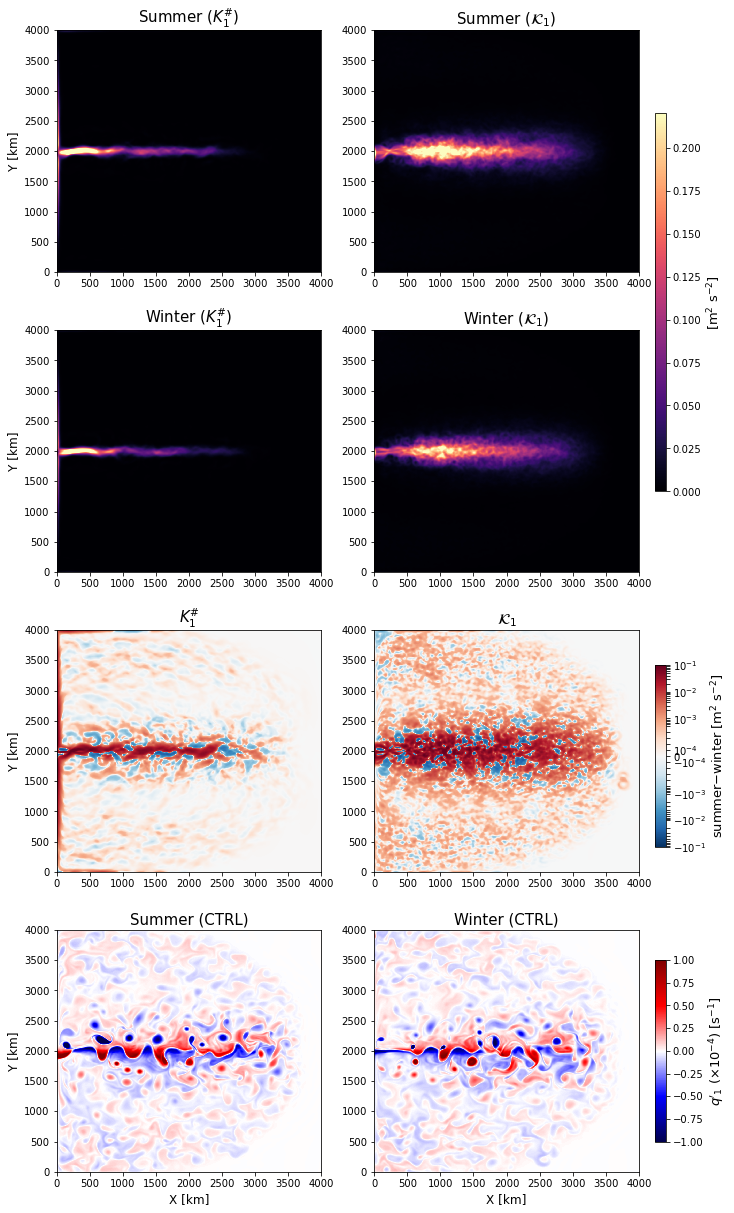

In [13]:
fig, axes = plt.subplots(figsize=(11,21), nrows=4, ncols=2)

im0 = axes[0,0].pcolormesh(ds.XC*Rd*1e-3, ds.YC*Rd*1e-3, MKE1s * U**2, 
#                            norm=clr.SymLogNorm(linthresh=1e-2, vmin=-1e1, vmax=1e1, base=10), 
                           vmin=0, vmax=.22,
                           cmap='magma', rasterized=True)
axes[0,1].pcolormesh(ds.XC*Rd*1e-3, ds.YC*Rd*1e-3, EKE1s * U**2, 
#                      norm=clr.SymLogNorm(linthresh=1e-2, vmin=-1e1, vmax=1e1, base=10), 
                     vmin=0, vmax=.22,
                     cmap='magma', rasterized=True)
im1 = axes[1,0].pcolormesh(ds.XC*Rd*1e-3, ds.YC*Rd*1e-3, MKE1w * U**2, 
#                            norm=clr.SymLogNorm(linthresh=1e-2, vmin=-1e1, vmax=1e1, base=10), 
                           vmin=0, vmax=.22,
                           cmap='magma', rasterized=True)
axes[1,1].pcolormesh(ds.XC*Rd*1e-3, ds.YC*Rd*1e-3, EKE1w * U**2, 
#                      norm=clr.SymLogNorm(linthresh=1e-2, vmin=-1e1, vmax=1e1, base=10), 
                     vmin=0, vmax=.22,
                     cmap='magma', rasterized=True)
im2 = axes[2,0].pcolormesh(ds.XC*Rd*1e-3, ds.YC*Rd*1e-3, (MKE1s-MKE1w) * U**2, 
                           norm=clr.SymLogNorm(linthresh=5e-4, vmin=-1e-1, vmax=1e-1, base=10), 
                           cmap='RdBu_r', rasterized=True)
axes[2,1].pcolormesh(ds.XC*Rd*1e-3, ds.YC*Rd*1e-3, (EKE1s-EKE1w) * U**2, 
                     norm=clr.SymLogNorm(linthresh=5e-4, vmin=-1e-1, vmax=1e-1, base=10), 
                     cmap='RdBu_r', rasterized=True)
im3 = axes[3,0].pcolormesh(ds.XC*Rd*1e-3, ds.YC*Rd*1e-3, qps * U/Rd*1e4,
                           vmin=-1e0, vmax=1e0, cmap='seismic',
                           rasterized=True)
axes[3,1].pcolormesh(ds.XC*Rd*1e-3, ds.YC*Rd*1e-3, qpw * U/Rd*1e4,
                     vmin=-1e0, vmax=1e0, cmap='seismic',
                     rasterized=True)

axes[0,0].set_title(r"Summer ($K^\#_1$)", fontsize=15)
axes[0,1].set_title(r"Summer ($\mathcal{K}_1$)", fontsize=15)
axes[1,0].set_title(r"Winter ($K^\#_1$)", fontsize=15)
axes[1,1].set_title(r"Winter ($\mathcal{K}_1$)", fontsize=15)
axes[2,0].set_title(r"$K^\#_1$", fontsize=15)
axes[2,1].set_title(r"$\mathcal{K}_1$", fontsize=15)
axes[3,0].set_title(r"Summer (CTRL)", fontsize=15)
axes[3,1].set_title(r"Winter (CTRL)", fontsize=15)
axes[0,0].set_ylabel(r"Y [km]", fontsize=12)
axes[1,0].set_ylabel(r"Y [km]", fontsize=12)
axes[2,0].set_ylabel(r"Y [km]", fontsize=12)
axes[3,0].set_ylabel(r"Y [km]", fontsize=12)
axes[3,0].set_xlabel(r"X [km]", fontsize=12)
axes[3,1].set_xlabel(r"X [km]", fontsize=12)

fig.subplots_adjust(right=0.86, hspace=.24) 
cax0 = fig.add_axes([0.88, 0.575, 0.014, 0.25])
cbar0 = fig.colorbar(im0, cax=cax0)
cbar0.set_label(r"[m$^2$ s$^{-2}$]", fontsize=13)
cax2 = fig.add_axes([0.88, 0.34, 0.014, 0.12])
cbar2 = fig.colorbar(im2, cax=cax2)
cbar2.set_label(r"summer$-$winter [m$^2$ s$^{-2}$]", fontsize=13)
cax3 = fig.add_axes([0.88, 0.145, 0.014, 0.12])
cbar3 = fig.colorbar(im3, cax=cax3)
cbar3.set_label(r"$q'_1\ (\times 10^{-4})$ [s$^{-1}$]", fontsize=13)

plt.savefig(op.join(rund,'Figs/KE_qp.pdf'))

In [9]:
HMKE = (dsE.MKE*ds.drF).sum(['Z','YC','XC']).compute() * dx**2 
HEKE = (dsE.EKE*ds.drF).sum(['Z','YC','XC']).compute() * dx**2 
HMAPE = dsE.MAPE.sum(['Zp1','YC','XC']).compute() * dx**2 
HEAPE = dsE.EAPE.sum(['Zp1','YC','XC']).compute() * dx**2 

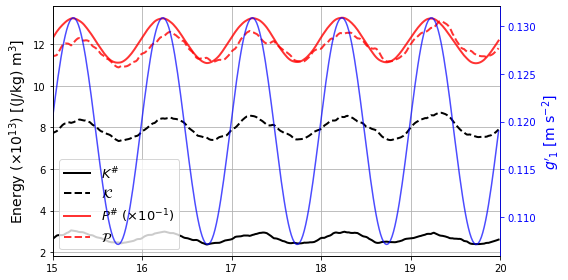

In [12]:
fig, ax1 = plt.subplots(figsize=(8,4))
fig.set_tight_layout(True)
ax2 = ax1.twinx()

# ax1.plot(np.linspace(7,10,5), np.zeros(5), c='gray',
#         lw=2)
# ax3.plot(np.linspace(7,10,5), np.zeros(5), c='gray',
#         lw=2)

ax1.plot((ds.time+ds.time[-1]-1)*T/(diny*86400), HMKE * U**2*H*Rd**2*1e-13, 'k', lw=2,
        label=r"$K^\#$")
ax1.plot((ds.time+ds.time[-1]-1)*T/(diny*86400), HEKE * U**2*H*Rd**2*1e-13, 'k--', lw=2,
        label=r"$\mathcal{K}$")
ax1.plot((ds.time+ds.time[-1]-1)*T/(diny*86400), HMAPE*.1 * U**2*H*Rd**2*1e-13, 'r', lw=2, alpha=.8,
        label=r"$P^\#\ (\times 10^{-1})$")
ax1.plot((ds.time+ds.time[-1]-1)*T/(diny*86400), HEAPE * U**2*H*Rd**2*1e-13, 'r--', lw=2, alpha=.8,
        label=r"$\mathcal{P}$")


ax2.plot((ds.time+ds.time[-1]-1)*T/(diny*86400), 
         gp.isel(Zp1=0) * U**2/(ds.drC.isel(Zp1=0)*H), 'b', alpha=.7)

# ax2.set_zorder(-1)
ax1.set_xlim([15.,20.])
# ax1.set_ylim([100.,900.])
ax1.legend(fontsize=13, loc='lower left').set_zorder(3)
ax1.grid(True)
ax1.set_ylabel(r"Energy ($\times 10^{13}$) [(J/kg) m$^3$]", fontsize=14)
ax2.set_ylabel(r"$g'_1$ [m s$^{-2}$]", fontsize=14, c='b')
ax2.spines['right'].set_color('b')
ax2.tick_params(axis='y', colors='b')

In [15]:
dtt = 7
ttstart = 0

for tt in range(ttstart,int(312/dtt)+1):

    if tt < 44:
        dsb = xr.open_zarr(op.join(rund,"Mean001/%03d-%03d" % (tt*dtt,tt*dtt+dtt-1)))
        dsp = xr.open_zarr(op.join(rund,"Eddy001/%03d-%03d" % (tt*dtt,tt*dtt+dtt-1)))
    else:
        dsb = xr.open_zarr(op.join(rund,"Mean001/%03d-%03d" % (308,311)))
        dsp = xr.open_zarr(op.join(rund,"Eddy001/%03d-%03d" % (308,311)))
        
    K1_K2 = -Rom**-1 * (dsb.wb.isel(Zp1=0)
                        * dsb.psip1b.isel(Zp1=0,Yp1=slice(1,-1),Xp1=slice(1,-1)).data
                       ) 
    k1_k2 = -Rom**-1 * (dsp.wp.isel(Zp1=0)
                        * dsp.psip1p.isel(Zp1=0,Yp1=slice(1,-1),Xp1=slice(1,-1)).data
                       ).mean('nmemb') 
    K2_K3 = -Rom**-1 * (dsb.wb.isel(Zp1=1)
                        * dsb.psip1b.isel(Zp1=1,Yp1=slice(1,-1),Xp1=slice(1,-1)).data
                       ) 
    k2_k3 = -Rom**-1 * (dsp.wp.isel(Zp1=1)
                        * dsp.psip1p.isel(Zp1=1,Yp1=slice(1,-1),Xp1=slice(1,-1)).data
                       ).mean('nmemb') 
    
    dsave = K1_K2.to_dataset(name='K1_K2')
    dsave['k1_k2'] = k1_k2
    dsave['K2_K3'] = K2_K3
    dsave['k2_k3'] = k2_k3
    dsave = dsave.drop_vars('Zp1').chunk({'YC':128,'XC':128})
    print(dsave)
    dsave.to_zarr(op.join(rund,'vKE001/%03d-%03d/' 
                          % (tt*dtt,tt*dtt+len(dsb.time)-1)), mode='w'
                 )
    dsave.close()
    dsb.close()
    dsp.close()
    print(tt)

<xarray.Dataset>
Dimensions:  (XC: 1024, YC: 1024, time: 7)
Coordinates:
  * XC       (XC) float64 0.03906 0.1172 0.1953 0.2734 ... 79.8 79.88 79.96
  * YC       (YC) float64 0.03906 0.1172 0.1953 0.2734 ... 79.8 79.88 79.96
  * time     (time) float32 311.0 312.0 313.0 314.0 315.0 316.0 317.0
Data variables:
    K1_K2    (time, YC, XC) float64 dask.array<chunksize=(7, 128, 128), meta=np.ndarray>
    k1_k2    (time, YC, XC) float64 dask.array<chunksize=(7, 128, 128), meta=np.ndarray>
    K2_K3    (time, YC, XC) float64 dask.array<chunksize=(7, 128, 128), meta=np.ndarray>
    k2_k3    (time, YC, XC) float64 dask.array<chunksize=(7, 128, 128), meta=np.ndarray>
0
<xarray.Dataset>
Dimensions:  (XC: 1024, YC: 1024, time: 7)
Coordinates:
  * XC       (XC) float64 0.03906 0.1172 0.1953 0.2734 ... 79.8 79.88 79.96
  * YC       (YC) float64 0.03906 0.1172 0.1953 0.2734 ... 79.8 79.88 79.96
  * time     (time) float32 318.0 319.0 320.0 321.0 322.0 323.0 324.0
Data variables:
    K1_K2    (time, 

distributed.utils_perf - WARNING - full garbage collections took 10% CPU time recently (threshold: 10%)


<xarray.Dataset>
Dimensions:  (XC: 1024, YC: 1024, time: 7)
Coordinates:
  * XC       (XC) float64 0.03906 0.1172 0.1953 0.2734 ... 79.8 79.88 79.96
  * YC       (YC) float64 0.03906 0.1172 0.1953 0.2734 ... 79.8 79.88 79.96
  * time     (time) float32 332.0 333.0 334.0 335.0 336.0 337.0 338.0
Data variables:
    K1_K2    (time, YC, XC) float64 dask.array<chunksize=(7, 128, 128), meta=np.ndarray>
    k1_k2    (time, YC, XC) float64 dask.array<chunksize=(7, 128, 128), meta=np.ndarray>
    K2_K3    (time, YC, XC) float64 dask.array<chunksize=(7, 128, 128), meta=np.ndarray>
    k2_k3    (time, YC, XC) float64 dask.array<chunksize=(7, 128, 128), meta=np.ndarray>


distributed.utils_perf - WARNING - full garbage collections took 10% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 10% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 11% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 14% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 14% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 14% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 14% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 14% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 20% CPU time recently (threshold: 10%)


3
<xarray.Dataset>
Dimensions:  (XC: 1024, YC: 1024, time: 7)
Coordinates:
  * XC       (XC) float64 0.03906 0.1172 0.1953 0.2734 ... 79.8 79.88 79.96
  * YC       (YC) float64 0.03906 0.1172 0.1953 0.2734 ... 79.8 79.88 79.96
  * time     (time) float32 339.0 340.0 341.0 342.0 343.0 344.0 345.0
Data variables:
    K1_K2    (time, YC, XC) float64 dask.array<chunksize=(7, 128, 128), meta=np.ndarray>
    k1_k2    (time, YC, XC) float64 dask.array<chunksize=(7, 128, 128), meta=np.ndarray>
    K2_K3    (time, YC, XC) float64 dask.array<chunksize=(7, 128, 128), meta=np.ndarray>
    k2_k3    (time, YC, XC) float64 dask.array<chunksize=(7, 128, 128), meta=np.ndarray>


distributed.utils_perf - WARNING - full garbage collections took 20% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 20% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 22% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 22% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 23% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 21% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 22% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 23% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 23% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took

4
<xarray.Dataset>
Dimensions:  (XC: 1024, YC: 1024, time: 7)
Coordinates:
  * XC       (XC) float64 0.03906 0.1172 0.1953 0.2734 ... 79.8 79.88 79.96
  * YC       (YC) float64 0.03906 0.1172 0.1953 0.2734 ... 79.8 79.88 79.96
  * time     (time) float32 346.0 347.0 348.0 349.0 350.0 351.0 352.0
Data variables:
    K1_K2    (time, YC, XC) float64 dask.array<chunksize=(7, 128, 128), meta=np.ndarray>
    k1_k2    (time, YC, XC) float64 dask.array<chunksize=(7, 128, 128), meta=np.ndarray>
    K2_K3    (time, YC, XC) float64 dask.array<chunksize=(7, 128, 128), meta=np.ndarray>
    k2_k3    (time, YC, XC) float64 dask.array<chunksize=(7, 128, 128), meta=np.ndarray>


distributed.utils_perf - WARNING - full garbage collections took 23% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 23% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 23% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 23% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 17% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 18% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 18% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 17% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 14% CPU time recently (threshold: 10%)


5
<xarray.Dataset>
Dimensions:  (XC: 1024, YC: 1024, time: 7)
Coordinates:
  * XC       (XC) float64 0.03906 0.1172 0.1953 0.2734 ... 79.8 79.88 79.96
  * YC       (YC) float64 0.03906 0.1172 0.1953 0.2734 ... 79.8 79.88 79.96
  * time     (time) float32 353.0 354.0 355.0 356.0 357.0 358.0 359.0
Data variables:
    K1_K2    (time, YC, XC) float64 dask.array<chunksize=(7, 128, 128), meta=np.ndarray>
    k1_k2    (time, YC, XC) float64 dask.array<chunksize=(7, 128, 128), meta=np.ndarray>
    K2_K3    (time, YC, XC) float64 dask.array<chunksize=(7, 128, 128), meta=np.ndarray>
    k2_k3    (time, YC, XC) float64 dask.array<chunksize=(7, 128, 128), meta=np.ndarray>


distributed.utils_perf - WARNING - full garbage collections took 14% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 14% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 14% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 14% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 14% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 14% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 15% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 15% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 13% CPU time recently (threshold: 10%)


6
<xarray.Dataset>
Dimensions:  (XC: 1024, YC: 1024, time: 7)
Coordinates:
  * XC       (XC) float64 0.03906 0.1172 0.1953 0.2734 ... 79.8 79.88 79.96
  * YC       (YC) float64 0.03906 0.1172 0.1953 0.2734 ... 79.8 79.88 79.96
  * time     (time) float32 360.0 361.0 362.0 363.0 364.0 365.0 366.0
Data variables:
    K1_K2    (time, YC, XC) float64 dask.array<chunksize=(7, 128, 128), meta=np.ndarray>
    k1_k2    (time, YC, XC) float64 dask.array<chunksize=(7, 128, 128), meta=np.ndarray>
    K2_K3    (time, YC, XC) float64 dask.array<chunksize=(7, 128, 128), meta=np.ndarray>
    k2_k3    (time, YC, XC) float64 dask.array<chunksize=(7, 128, 128), meta=np.ndarray>


distributed.utils_perf - WARNING - full garbage collections took 13% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 13% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 13% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 13% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 13% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 13% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 13% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 13% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 11% CPU time recently (threshold: 10%)


7
<xarray.Dataset>
Dimensions:  (XC: 1024, YC: 1024, time: 7)
Coordinates:
  * XC       (XC) float64 0.03906 0.1172 0.1953 0.2734 ... 79.8 79.88 79.96
  * YC       (YC) float64 0.03906 0.1172 0.1953 0.2734 ... 79.8 79.88 79.96
  * time     (time) float32 367.0 368.0 369.0 370.0 371.0 372.0 373.0
Data variables:
    K1_K2    (time, YC, XC) float64 dask.array<chunksize=(7, 128, 128), meta=np.ndarray>
    k1_k2    (time, YC, XC) float64 dask.array<chunksize=(7, 128, 128), meta=np.ndarray>
    K2_K3    (time, YC, XC) float64 dask.array<chunksize=(7, 128, 128), meta=np.ndarray>
    k2_k3    (time, YC, XC) float64 dask.array<chunksize=(7, 128, 128), meta=np.ndarray>


distributed.utils_perf - WARNING - full garbage collections took 11% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 11% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 11% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 11% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 11% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 11% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 12% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 11% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 10% CPU time recently (threshold: 10%)


8
<xarray.Dataset>
Dimensions:  (XC: 1024, YC: 1024, time: 7)
Coordinates:
  * XC       (XC) float64 0.03906 0.1172 0.1953 0.2734 ... 79.8 79.88 79.96
  * YC       (YC) float64 0.03906 0.1172 0.1953 0.2734 ... 79.8 79.88 79.96
  * time     (time) float32 374.0 375.0 376.0 377.0 378.0 379.0 380.0
Data variables:
    K1_K2    (time, YC, XC) float64 dask.array<chunksize=(7, 128, 128), meta=np.ndarray>
    k1_k2    (time, YC, XC) float64 dask.array<chunksize=(7, 128, 128), meta=np.ndarray>
    K2_K3    (time, YC, XC) float64 dask.array<chunksize=(7, 128, 128), meta=np.ndarray>
    k2_k3    (time, YC, XC) float64 dask.array<chunksize=(7, 128, 128), meta=np.ndarray>


distributed.utils_perf - WARNING - full garbage collections took 10% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 10% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 10% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 10% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 10% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 10% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 10% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 10% CPU time recently (threshold: 10%)


9
<xarray.Dataset>
Dimensions:  (XC: 1024, YC: 1024, time: 7)
Coordinates:
  * XC       (XC) float64 0.03906 0.1172 0.1953 0.2734 ... 79.8 79.88 79.96
  * YC       (YC) float64 0.03906 0.1172 0.1953 0.2734 ... 79.8 79.88 79.96
  * time     (time) float32 381.0 382.0 383.0 384.0 385.0 386.0 387.0
Data variables:
    K1_K2    (time, YC, XC) float64 dask.array<chunksize=(7, 128, 128), meta=np.ndarray>
    k1_k2    (time, YC, XC) float64 dask.array<chunksize=(7, 128, 128), meta=np.ndarray>
    K2_K3    (time, YC, XC) float64 dask.array<chunksize=(7, 128, 128), meta=np.ndarray>
    k2_k3    (time, YC, XC) float64 dask.array<chunksize=(7, 128, 128), meta=np.ndarray>
10
<xarray.Dataset>
Dimensions:  (XC: 1024, YC: 1024, time: 7)
Coordinates:
  * XC       (XC) float64 0.03906 0.1172 0.1953 0.2734 ... 79.8 79.88 79.96
  * YC       (YC) float64 0.03906 0.1172 0.1953 0.2734 ... 79.8 79.88 79.96
  * time     (time) float32 388.0 389.0 390.0 391.0 392.0 393.0 394.0
Data variables:
    K1_K2    (tim

distributed.utils_perf - WARNING - full garbage collections took 10% CPU time recently (threshold: 10%)


32
<xarray.Dataset>
Dimensions:  (XC: 1024, YC: 1024, time: 7)
Coordinates:
  * XC       (XC) float64 0.03906 0.1172 0.1953 0.2734 ... 79.8 79.88 79.96
  * YC       (YC) float64 0.03906 0.1172 0.1953 0.2734 ... 79.8 79.88 79.96
  * time     (time) float32 542.0 543.0 544.0 545.0 546.0 547.0 548.0
Data variables:
    K1_K2    (time, YC, XC) float64 dask.array<chunksize=(7, 128, 128), meta=np.ndarray>
    k1_k2    (time, YC, XC) float64 dask.array<chunksize=(7, 128, 128), meta=np.ndarray>
    K2_K3    (time, YC, XC) float64 dask.array<chunksize=(7, 128, 128), meta=np.ndarray>
    k2_k3    (time, YC, XC) float64 dask.array<chunksize=(7, 128, 128), meta=np.ndarray>


distributed.utils_perf - WARNING - full garbage collections took 10% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 10% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 10% CPU time recently (threshold: 10%)


33
<xarray.Dataset>
Dimensions:  (XC: 1024, YC: 1024, time: 7)
Coordinates:
  * XC       (XC) float64 0.03906 0.1172 0.1953 0.2734 ... 79.8 79.88 79.96
  * YC       (YC) float64 0.03906 0.1172 0.1953 0.2734 ... 79.8 79.88 79.96
  * time     (time) float32 549.0 550.0 551.0 552.0 553.0 554.0 555.0
Data variables:
    K1_K2    (time, YC, XC) float64 dask.array<chunksize=(7, 128, 128), meta=np.ndarray>
    k1_k2    (time, YC, XC) float64 dask.array<chunksize=(7, 128, 128), meta=np.ndarray>
    K2_K3    (time, YC, XC) float64 dask.array<chunksize=(7, 128, 128), meta=np.ndarray>
    k2_k3    (time, YC, XC) float64 dask.array<chunksize=(7, 128, 128), meta=np.ndarray>


distributed.utils_perf - WARNING - full garbage collections took 10% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 10% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 10% CPU time recently (threshold: 10%)


34
<xarray.Dataset>
Dimensions:  (XC: 1024, YC: 1024, time: 7)
Coordinates:
  * XC       (XC) float64 0.03906 0.1172 0.1953 0.2734 ... 79.8 79.88 79.96
  * YC       (YC) float64 0.03906 0.1172 0.1953 0.2734 ... 79.8 79.88 79.96
  * time     (time) float32 556.0 557.0 558.0 559.0 560.0 561.0 562.0
Data variables:
    K1_K2    (time, YC, XC) float64 dask.array<chunksize=(7, 128, 128), meta=np.ndarray>
    k1_k2    (time, YC, XC) float64 dask.array<chunksize=(7, 128, 128), meta=np.ndarray>
    K2_K3    (time, YC, XC) float64 dask.array<chunksize=(7, 128, 128), meta=np.ndarray>
    k2_k3    (time, YC, XC) float64 dask.array<chunksize=(7, 128, 128), meta=np.ndarray>


distributed.utils_perf - WARNING - full garbage collections took 10% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 10% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 10% CPU time recently (threshold: 10%)


35


distributed.utils_perf - WARNING - full garbage collections took 10% CPU time recently (threshold: 10%)


<xarray.Dataset>
Dimensions:  (XC: 1024, YC: 1024, time: 7)
Coordinates:
  * XC       (XC) float64 0.03906 0.1172 0.1953 0.2734 ... 79.8 79.88 79.96
  * YC       (YC) float64 0.03906 0.1172 0.1953 0.2734 ... 79.8 79.88 79.96
  * time     (time) float32 563.0 564.0 565.0 566.0 567.0 568.0 569.0
Data variables:
    K1_K2    (time, YC, XC) float64 dask.array<chunksize=(7, 128, 128), meta=np.ndarray>
    k1_k2    (time, YC, XC) float64 dask.array<chunksize=(7, 128, 128), meta=np.ndarray>
    K2_K3    (time, YC, XC) float64 dask.array<chunksize=(7, 128, 128), meta=np.ndarray>
    k2_k3    (time, YC, XC) float64 dask.array<chunksize=(7, 128, 128), meta=np.ndarray>


distributed.utils_perf - WARNING - full garbage collections took 10% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 10% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 10% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 10% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 10% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 10% CPU time recently (threshold: 10%)


36
<xarray.Dataset>
Dimensions:  (XC: 1024, YC: 1024, time: 7)
Coordinates:
  * XC       (XC) float64 0.03906 0.1172 0.1953 0.2734 ... 79.8 79.88 79.96
  * YC       (YC) float64 0.03906 0.1172 0.1953 0.2734 ... 79.8 79.88 79.96
  * time     (time) float32 570.0 571.0 572.0 573.0 574.0 575.0 576.0
Data variables:
    K1_K2    (time, YC, XC) float64 dask.array<chunksize=(7, 128, 128), meta=np.ndarray>
    k1_k2    (time, YC, XC) float64 dask.array<chunksize=(7, 128, 128), meta=np.ndarray>
    K2_K3    (time, YC, XC) float64 dask.array<chunksize=(7, 128, 128), meta=np.ndarray>
    k2_k3    (time, YC, XC) float64 dask.array<chunksize=(7, 128, 128), meta=np.ndarray>


distributed.utils_perf - WARNING - full garbage collections took 10% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 10% CPU time recently (threshold: 10%)


37
<xarray.Dataset>
Dimensions:  (XC: 1024, YC: 1024, time: 7)
Coordinates:
  * XC       (XC) float64 0.03906 0.1172 0.1953 0.2734 ... 79.8 79.88 79.96
  * YC       (YC) float64 0.03906 0.1172 0.1953 0.2734 ... 79.8 79.88 79.96
  * time     (time) float32 577.0 578.0 579.0 580.0 581.0 582.0 583.0
Data variables:
    K1_K2    (time, YC, XC) float64 dask.array<chunksize=(7, 128, 128), meta=np.ndarray>
    k1_k2    (time, YC, XC) float64 dask.array<chunksize=(7, 128, 128), meta=np.ndarray>
    K2_K3    (time, YC, XC) float64 dask.array<chunksize=(7, 128, 128), meta=np.ndarray>
    k2_k3    (time, YC, XC) float64 dask.array<chunksize=(7, 128, 128), meta=np.ndarray>


distributed.utils_perf - WARNING - full garbage collections took 10% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 10% CPU time recently (threshold: 10%)


38
<xarray.Dataset>
Dimensions:  (XC: 1024, YC: 1024, time: 7)
Coordinates:
  * XC       (XC) float64 0.03906 0.1172 0.1953 0.2734 ... 79.8 79.88 79.96
  * YC       (YC) float64 0.03906 0.1172 0.1953 0.2734 ... 79.8 79.88 79.96
  * time     (time) float32 584.0 585.0 586.0 587.0 588.0 589.0 590.0
Data variables:
    K1_K2    (time, YC, XC) float64 dask.array<chunksize=(7, 128, 128), meta=np.ndarray>
    k1_k2    (time, YC, XC) float64 dask.array<chunksize=(7, 128, 128), meta=np.ndarray>
    K2_K3    (time, YC, XC) float64 dask.array<chunksize=(7, 128, 128), meta=np.ndarray>
    k2_k3    (time, YC, XC) float64 dask.array<chunksize=(7, 128, 128), meta=np.ndarray>


distributed.utils_perf - WARNING - full garbage collections took 10% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 10% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 10% CPU time recently (threshold: 10%)


39
<xarray.Dataset>
Dimensions:  (XC: 1024, YC: 1024, time: 7)
Coordinates:
  * XC       (XC) float64 0.03906 0.1172 0.1953 0.2734 ... 79.8 79.88 79.96
  * YC       (YC) float64 0.03906 0.1172 0.1953 0.2734 ... 79.8 79.88 79.96
  * time     (time) float32 591.0 592.0 593.0 594.0 595.0 596.0 597.0
Data variables:
    K1_K2    (time, YC, XC) float64 dask.array<chunksize=(7, 128, 128), meta=np.ndarray>
    k1_k2    (time, YC, XC) float64 dask.array<chunksize=(7, 128, 128), meta=np.ndarray>
    K2_K3    (time, YC, XC) float64 dask.array<chunksize=(7, 128, 128), meta=np.ndarray>
    k2_k3    (time, YC, XC) float64 dask.array<chunksize=(7, 128, 128), meta=np.ndarray>


distributed.utils_perf - WARNING - full garbage collections took 10% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 10% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 10% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 10% CPU time recently (threshold: 10%)


40
<xarray.Dataset>
Dimensions:  (XC: 1024, YC: 1024, time: 7)
Coordinates:
  * XC       (XC) float64 0.03906 0.1172 0.1953 0.2734 ... 79.8 79.88 79.96
  * YC       (YC) float64 0.03906 0.1172 0.1953 0.2734 ... 79.8 79.88 79.96
  * time     (time) float32 598.0 599.0 600.0 601.0 602.0 603.0 604.0
Data variables:
    K1_K2    (time, YC, XC) float64 dask.array<chunksize=(7, 128, 128), meta=np.ndarray>
    k1_k2    (time, YC, XC) float64 dask.array<chunksize=(7, 128, 128), meta=np.ndarray>
    K2_K3    (time, YC, XC) float64 dask.array<chunksize=(7, 128, 128), meta=np.ndarray>
    k2_k3    (time, YC, XC) float64 dask.array<chunksize=(7, 128, 128), meta=np.ndarray>


distributed.utils_perf - WARNING - full garbage collections took 10% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 10% CPU time recently (threshold: 10%)


41
<xarray.Dataset>
Dimensions:  (XC: 1024, YC: 1024, time: 7)
Coordinates:
  * XC       (XC) float64 0.03906 0.1172 0.1953 0.2734 ... 79.8 79.88 79.96
  * YC       (YC) float64 0.03906 0.1172 0.1953 0.2734 ... 79.8 79.88 79.96
  * time     (time) float32 605.0 606.0 607.0 608.0 609.0 610.0 611.0
Data variables:
    K1_K2    (time, YC, XC) float64 dask.array<chunksize=(7, 128, 128), meta=np.ndarray>
    k1_k2    (time, YC, XC) float64 dask.array<chunksize=(7, 128, 128), meta=np.ndarray>
    K2_K3    (time, YC, XC) float64 dask.array<chunksize=(7, 128, 128), meta=np.ndarray>
    k2_k3    (time, YC, XC) float64 dask.array<chunksize=(7, 128, 128), meta=np.ndarray>


distributed.utils_perf - WARNING - full garbage collections took 10% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 10% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 10% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 10% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 10% CPU time recently (threshold: 10%)


42
<xarray.Dataset>
Dimensions:  (XC: 1024, YC: 1024, time: 7)
Coordinates:
  * XC       (XC) float64 0.03906 0.1172 0.1953 0.2734 ... 79.8 79.88 79.96
  * YC       (YC) float64 0.03906 0.1172 0.1953 0.2734 ... 79.8 79.88 79.96
  * time     (time) float32 612.0 613.0 614.0 615.0 616.0 617.0 618.0
Data variables:
    K1_K2    (time, YC, XC) float64 dask.array<chunksize=(7, 128, 128), meta=np.ndarray>
    k1_k2    (time, YC, XC) float64 dask.array<chunksize=(7, 128, 128), meta=np.ndarray>
    K2_K3    (time, YC, XC) float64 dask.array<chunksize=(7, 128, 128), meta=np.ndarray>
    k2_k3    (time, YC, XC) float64 dask.array<chunksize=(7, 128, 128), meta=np.ndarray>


distributed.utils_perf - WARNING - full garbage collections took 10% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 10% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 10% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 10% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 10% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 10% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 10% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 10% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 10% CPU time recently (threshold: 10%)


43
<xarray.Dataset>
Dimensions:  (XC: 1024, YC: 1024, time: 4)
Coordinates:
  * XC       (XC) float64 0.03906 0.1172 0.1953 0.2734 ... 79.8 79.88 79.96
  * YC       (YC) float64 0.03906 0.1172 0.1953 0.2734 ... 79.8 79.88 79.96
  * time     (time) float32 619.0 620.0 621.0 622.0
Data variables:
    K1_K2    (time, YC, XC) float64 dask.array<chunksize=(4, 128, 128), meta=np.ndarray>
    k1_k2    (time, YC, XC) float64 dask.array<chunksize=(4, 128, 128), meta=np.ndarray>
    K2_K3    (time, YC, XC) float64 dask.array<chunksize=(4, 128, 128), meta=np.ndarray>
    k2_k3    (time, YC, XC) float64 dask.array<chunksize=(4, 128, 128), meta=np.ndarray>


distributed.utils_perf - WARNING - full garbage collections took 10% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 10% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 10% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 10% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 10% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 10% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 10% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 10% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 10% CPU time recently (threshold: 10%)


44


In [ ]:
dtt = 7
ttstart = 0

for tt in range(ttstart,int(312/dtt)+1):

    if tt < 44:
        dsb = xr.open_zarr(op.join(rund,"Mean001/%03d-%03d" % (tt*dtt,tt*dtt+dtt-1)))
        dsp = xr.open_zarr(op.join(rund,"Eddy001/%03d-%03d" % (tt*dtt,tt*dtt+dtt-1)))
    else:
        dsb = xr.open_zarr(op.join(rund,"Mean001/%03d-%03d" % (308,311)))
        dsp = xr.open_zarr(op.join(rund,"Eddy001/%03d-%03d" % (308,311)))
        
    if tt == ttstart:
        grid = Grid(dsb, periodic=[],
                    coords={'Z':{'center':'Z','inner':'Zp1'},
                            'Y':{'center':'YC','left':'YG'},
                            'X':{'center':'XC','left':'XG'}}
                   )
        
    dpsip_z = xr.DataArray(-grid.diff(dsp.psip.isel(Yp1=slice(1,-1),Xp1=slice(1,-1)),
                                      'Z').data,
                           dims=['nmemb','time','Zp1','YC','XC'], 
                           coords={'nmemb':dsp.nmemb.data,'time':dsp.time.data,
                                   'Zp1':dsp.Zp1.data,
                                   'YC':dsp.YC.data,'XC':dsp.XC.data}
                          )
    
    p1_k1 = ((dsp.wp.isel(Zp1=0) * dpsip_z.isel(Zp1=0)).mean('nmemb') / Rom 
             * ds.drF.isel(Z=0)/(ds.drF.isel(Z=0)+ds.drF.isel(Z=1)))
    p1_k2 = ((dsp.wp.isel(Zp1=0) * dpsip_z.isel(Zp1=0)).mean('nmemb') / Rom 
             * ds.drF.isel(Z=1)/(ds.drF.isel(Z=0)+ds.drF.isel(Z=1)))
    p2_k2 = ((dsp.wp.isel(Zp1=1) * dpsip_z.isel(Zp1=1)).mean('nmemb') / Rom 
             * ds.drF.isel(Z=1)/(ds.drF.isel(Z=1)+ds.drF.isel(Z=2)))
    p2_k3 = ((dsp.wp.isel(Zp1=1) * dpsip_z.isel(Zp1=1)).mean('nmemb') / Rom 
             * ds.drF.isel(Z=2)/(ds.drF.isel(Z=1)+ds.drF.isel(Z=2)))
    
    dsave = p1_k1.to_dataset(name='p1_k1')
    dsave['p1_k2'] = p1_k2
    dsave['p2_k2'] = p2_k2
    dsave['p2_k3'] = p2_k3
    dsave = dsave.drop_vars('Zp1').chunk({'YC':128,'XC':128})
    print(dsave)
    dsave.to_zarr(op.join(rund,'vPE001/%03d-%03d/' 
                          % (tt*dtt,tt*dtt+len(dsb.time)-1)), mode='w'
                 )
    dsave.close()
    dsb.close()
    dsp.close()
    print(tt)

In [6]:
dtt = 7
for tt in range(int(312/dtt)+1):
    if tt < 44:
        if tt == 0:
            dsP = xr.open_zarr(op.join(rund,"Pis001/%03d-%03d" % (tt*dtt,tt*dtt+dtt-1)))
        else:
            dsP = xr.concat([dsP,xr.open_zarr(op.join(rund,"Pis001/%03d-%03d" 
                                                      % (tt*dtt,tt*dtt+dtt-1)))
                            ], 'time')
    else:
        dsP = xr.concat([dsP,xr.open_zarr(op.join(rund,"Pis001/%03d-%03d" 
                                                  % (308,311)))
                        ], 'time')

In [43]:
p_k_1 = dsP.p_k.isel(Zp1=0).sum(['YC','XC']).compute() * dx**2
p_k_2 = dsP.p_k.isel(Zp1=1).sum(['YC','XC']).compute() * dx**2

In [44]:
P_K_1 = dsP.P_K.isel(Zp1=0).sum(['YC','XC']).compute() * dx**2
P_K_2 = dsP.P_K.isel(Zp1=1).sum(['YC','XC']).compute() * dx**2

In [18]:
K1_k1 = (dsP.K_k.isel(Z=0).sum(['YC','XC']).compute() 
         * ds.Z.isel(Z=0).data
        ) * dx**2
K2_k2 = (dsP.K_k.isel(Z=1).sum(['YC','XC']).compute()
         * ds.Z.isel(Z=1).data
        ) * dx**2
K3_k3 = (dsP.K_k.isel(Z=2).sum(['YC','XC']).compute()
         * ds.Z.isel(Z=2).data
        ) * dx**2

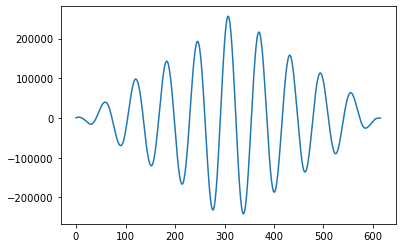

In [35]:
plt.plot(np.correlate((k1_k2-k1_k2.mean()).rolling(time=5, center=True).mean()[2:-2], 
                              (gp.isel(Zp1=0)-gp.isel(Zp1=0).mean())[2:-2], mode='full'
                             ))

In [16]:
print((np.argmax(np.correlate((HMKE-HMKE.mean()), 
                              (gp.isel(Zp1=0)-gp.isel(Zp1=0).mean()), mode='full'
                             )) - (ntime - 1.)
      ) * T/86400.)
print((np.argmax(np.correlate((HEKE-HEKE.mean()), 
                              (gp.isel(Zp1=0)-gp.isel(Zp1=0).mean()), mode='full'
                             )) - (ntime - 1.)
      ) * T/86400.)
print((np.argmax(np.correlate((HMAPE-HMAPE.mean()), 
                              (gp.isel(Zp1=0)-gp.isel(Zp1=0).mean()), mode='full'
                             )) - (ntime - 1.)
      ) * T/86400.)
print((np.argmax(np.correlate((HEAPE-HEAPE.mean()), 
                              (gp.isel(Zp1=0)-gp.isel(Zp1=0).mean()), mode='full'
                             )) - (ntime - 1.)
      ) * T/86400.)

11.574074074074074
17.36111111111111
0.0
17.36111111111111


In [23]:
client.close()